# Idealed Sensitivity Study

## Case 1 - Winter Clear

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from netCDF4 import Dataset

from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair,
                 get_basemap, latlon_coords, g_geoht, combine_files, ALL_TIMES)

plt.style.use('default')

# N-ICE Measurements
# SEB Measurements are in UTC
Measurements_seb = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_sebData_v1.nc', decode_times = False)

M_downlw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_longwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])
M_uplw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_longwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])

M_downsw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_shortwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])
M_upsw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_shortwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])

M_lat = -pd.DataFrame(Measurements_seb.variables['surface_downward_latent_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lh'])
M_sen = -pd.DataFrame(Measurements_seb.variables['surface_downward_sensible_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sh'])
# sensible and latent heat flux negative to match WRF sign convention

## Case 2 - Spring Cloudy

In [2]:
sdate = '2015-05-02'
edate = '2015-05-05' 

M_net = (M_downlw['lw'] - M_uplw['lw'])
sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)


### Clouds

In [3]:
fns = glob('/Volumes/seagate_desktop/idealized/case4/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))

dbz = getvar(wrflist, "dbz", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
dbz_df = pd.DataFrame(dbz.values, index = dbz.Time.values, columns = z)

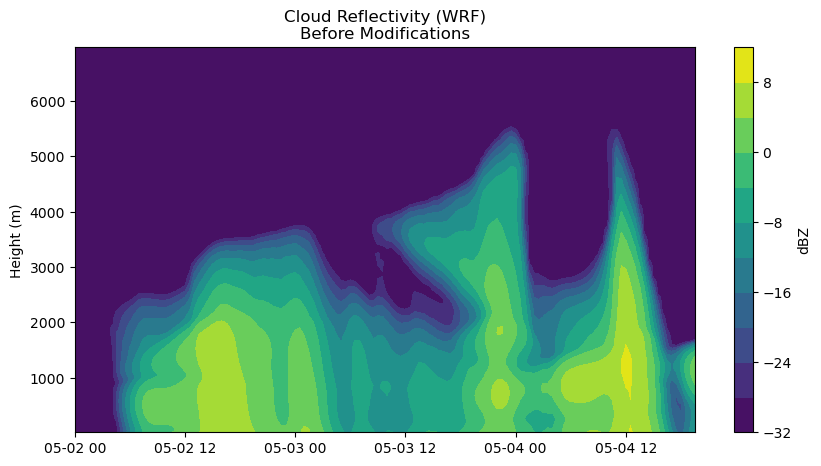

In [19]:
plt.figure(figsize = (10,5))
plt.contourf(dbz_df.index, dbz_df.columns, dbz_df.T.values, levels = 10)
plt.ylabel('Height (m)')
plt.title('Cloud Reflectivity (WRF)\nBefore Modifications')
plt.colorbar(label = 'dBZ');

### Sensible and Latent Heat Flux

In [17]:
lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

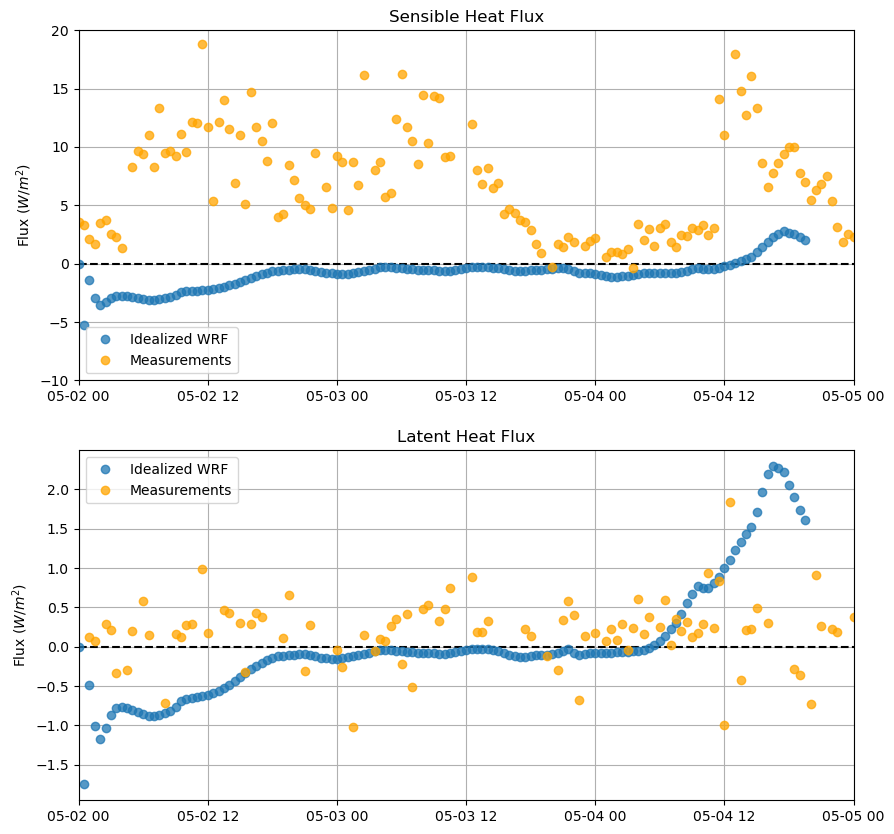

In [18]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(case4_sh, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
plt.ylim(-10,20)
plt.xlim(sdate,'2015-05-05');

plt.subplot(212)
plt.plot(case4_lh, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
plt.xlim(sdate,'2015-05-05');


### Longwave Radiation & Shortwave Radiation

In [22]:
lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwupb.Time.values)

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)


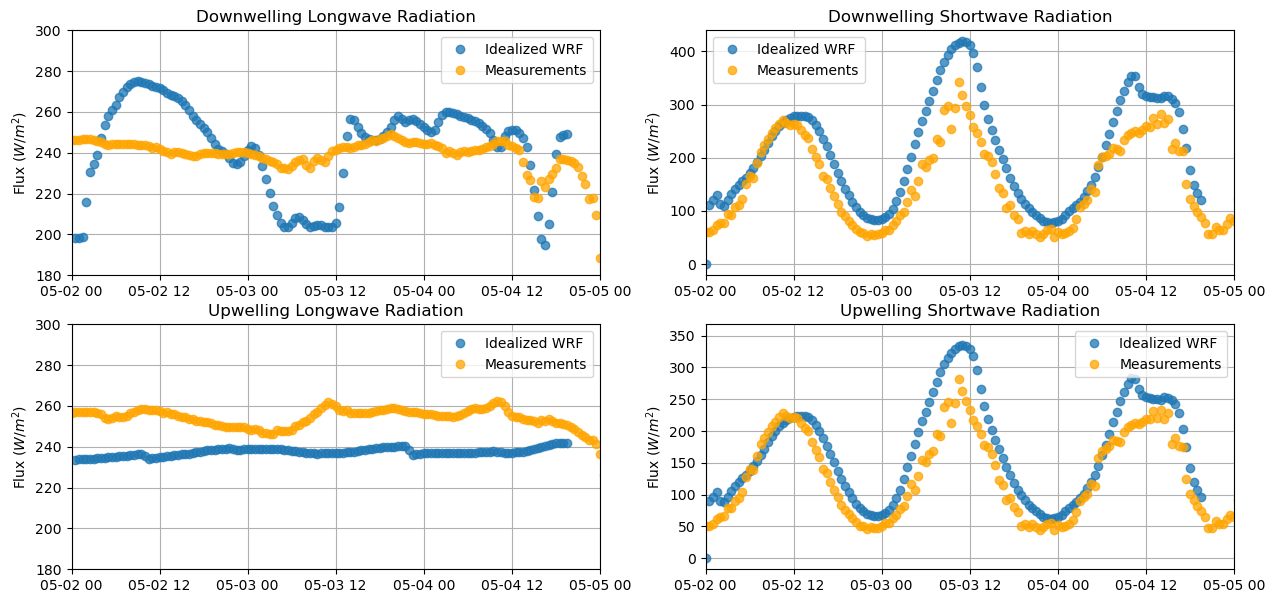

In [25]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF', 'Measurements'])
plt.ylim(180,300)
plt.xlim(sdate,'2015-05-05');

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(180, 300)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-05');

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.legend(['Idealized WRF', 'Measurements'])
#plt.ylim(180,300)
plt.xlim(sdate,'2015-05-05');

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
#plt.ylim(180, 300)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-05');



## Case 3 - Spring Clear

In [ ]:
sdate = '2015-05-22'
edate = '2015-05-25' 

M_net = (M_downlw['lw'] - M_uplw['lw'])
sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

fns = glob('/Volumes/seagate_desktop/idealized/case3/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))

### Clouds

In [ ]:
dbz = getvar(wrflist, "dbz", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
dbz_df = pd.DataFrame(dbz.values, index = dbz.Time.values, columns = z)

In [ ]:
plt.figure(figsize = (10,5))
plt.contourf(dbz_df.index, dbz_df.columns, dbz_df.T.values, levels = 10)
plt.ylabel('Height (m)')
plt.title('Cloud Reflectivity (WRF)\nBefore Modifications')
plt.colorbar(label = 'dBZ');

### Sensible and Latent Heat Flux

In [ ]:
lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(case4_sh, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-25', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
plt.ylim(-10,20)
plt.xlim(sdate,'2015-05-05');

plt.subplot(212)
plt.plot(case4_lh, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'orange')
plt.hlines(0, xmin = sdate, xmax = '2015-05-25', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Pre-Modification', 'Measurements'])
plt.xlim(sdate,'2015-05-25');


### Longwave Radiation & Shortwave Radiation

In [ ]:
lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwupb.Time.values)

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)


In [ ]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF', 'Measurements'])
plt.ylim(180,300)
plt.xlim(sdate,'2015-05-25');

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(180, 300)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-25');

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.legend(['Idealized WRF', 'Measurements'])
#plt.ylim(180,300)
plt.xlim(sdate,'2015-05-25');

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'orange')
#plt.hlines(0, xmin = sdate, xmax = '2015-05-05', linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
#plt.ylim(180, 300)
plt.legend(['Idealized WRF', 'Measurements'])
plt.xlim(sdate,'2015-05-25');


## Statistics and Summary